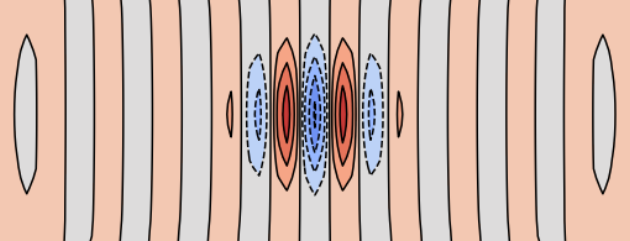


# Lab 3: Shallow water Rossby waves

In this lab, we will simulate barotropic flow on a $\beta$-plane and discuss: 

- geostrophic streamfunction, velocity field, and potential vorticity
- Rossby waves, phase and group velocity
- the role of the planetary vorticity gradient and mean flow
- the effect of nonlinearity

To use this notebook, you will need Python 3 and the latest version of [Dedalus](http://dedalus-project.org/) installed on your local machine. 

# Background

## Shallow water model on a $\beta$-plane

The equations of motion for a single-layer shallow water model of depth $H$ on a $\beta$-plane are

$$
\partial_t Q + \mathbf{u} \cdot \nabla Q = 0,
$$

where $u = - \partial_y \psi$, $v = \partial_x \psi$ is the velocity field, $\psi$ is the geostrophic streamfunction, and 

$$
Q = \frac{f + \zeta}{H}
$$

is the shallow-water potential vorticity. In this expression, $\zeta$ is the $z$-component of the relative vorticity

$$
\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} = \nabla^2 \psi.
$$

Let's write $f = f_0 + \beta y$, where $\beta$ is the planetary vorticity gradient, and neglect variations in the depth of the fluid, $H$. For simplicity, we set $H = 1$. Then the shallow water potential vorticity is

$$
Q = f_0 + \beta y + \nabla^2 \psi.
$$

## Base state and perturbations

We now introduce a base state with an eastward mean flow $U$ in the $x$-direction. The streamfunction, velocity field, and potential vorticity for this state is

$$
\overline{\psi} = - U y, \qquad \overline{\mathbf{u}} = \left( U, 0 \right), \qquad \overline{Q} = f_0 + \beta y.
$$

We will allow perturbations to this base state, i.e.

$$
\psi = -U y + \psi', \qquad \mathbf{u'} = \left( U + u', v' \right), \qquad Q = f_0 +  \beta y + q',  
$$

where the streamfunction, velocity, and potential vorticity perturbations are related by

$$
u' = - \partial_y \psi', \qquad v' = \partial_x \psi', \qquad q' = \nabla^2 \psi'.
$$ 


## Nonlinearity and the Jacobian operator

We will drop the dashes on the perturbation variables from here on. The equation of motion for the perturbation potential vorticity $q$ is

$$
\partial_t q + \mathbf{u} \cdot \nabla q + U \, \partial_x q + \beta \, \partial_x \psi = 0
$$

The nonlinear term in this equation is $\mathbf{u} \cdot \nabla q$. We note that it can be written as

$$
u \, \partial_x q + v \, \partial_y q = - \partial_y \psi \, \partial_x q + \partial_x \psi \, \partial_y q = J(\psi, q).
$$

The operator $J(\psi, q)$ is called the *Jacobian operator*. It allows us to directly calculate the nonlinearity from the streamfunction and the potential vorticity. Thus, we don't need to calculate the velocities $u$, $v$. 

We would like to explore the role of the nonlinear term in this lab. So we will rewrite the equation of motion as 

$$
\partial_t q + U \, \partial_x q + \beta \, \partial_x \psi = - \epsilon \; J \left( \psi, q \right). 
$$

This allows us to "turn off" the nonlinear term by setting $\epsilon = 0$, and turn it back on by setting $\epsilon = 1$. 

## Rossby waves

For linear dynamics ($\epsilon = 0$), the streamfunction $\psi$ satisfies the equation

$$
\partial_t \nabla^2 \psi + U \partial_x \nabla^2 \psi + \beta \partial_x \psi = 0, 
$$

where we have made use of $q = \nabla^2 \psi$. We now assume wave-like solutions of the form

$$
\psi(x,y,t) = \tilde{\psi} \; \mbox{e}^{\mbox{i} \left( k x + l y - \omega t \right)},
$$

where $\tilde{\psi}$ is the amplitude of the wave, $(k,l)$ is the (two-dimensional) wavevector, and $\omega$ is the (angular) frequency of the wave. By substituting this into the linearized equation, you can show that this gives

$$
i \left( \omega - U k \right) \left( k^2 + l^2 \right) \; \tilde{\psi} + i \, \beta \, k \; \tilde{\psi} = 0
$$

which has non-trivial solutions if

$$
\omega = U k - \frac{\beta k}{k^2 + l^2}.
$$

This is the dispersion relation for *Rossby waves*. 

## Phase velocity and group velocity

The phase velocity of Rossby waves is 

$$
c_\mathrm{ph} = \frac{\omega}{k} = U - \frac{\beta}{k^2 + l^2}. 
$$

We have seen that the phase velocity is the speed at which wave crests propagate. Interestingly, in the absence of a mean flow ($U = 0$) Rossby wave crests will always propagate to the west. That is because both $\beta$ and $k^2 + l^2$ are positive, so the overall phase speed is always in the *negative* $x$-direction, that is, westwards. However, we can make the wave crests propagate towards the east if we have mean eastward flow $U$ that is large enough to overcome their westward propagation. 

In nature, we rarely deal with situations where there is only one wave. Rather, waves of different wavelengths are usually superimposed in the form of a *wavepacket*. Within the wave packet, individual wave crests will propagate with their phase speed, but the overall wavepacket will move with a speed given by the *group velocity*

$$
c_\mathrm{gr} = \frac{\partial \omega}{\partial k} = U - \beta \frac{l^2 - k^2}{\left( k^2 + l^2 \right)^2}. 
$$

Unlike the phase velocity, the group velocity for Rossby waves can take either sign. That means that a wavepacket of Rossby waves can propagate westward or eastward, even though Rossby waves themselves can only propagate westwards. 

In this lab, we will explore the difference between phase velocity and group velocity in more detail. 

# Experimental set-up

## Libraries

We start by importing the usual libraries for Dedalus, Numpy, and Matplotlib. 

In [ ]:
from dedalus import public as de
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Basis and domains

We will work in a rectangular domain of length `Lx = 16` and width `Ly = 8`. For simplicity, we will use periodic boundary conditions on each side of the domain. We do this by choosing the basis functions in the $x$ and $y$ directions to be Fourier (sines and cosines). 

In [ ]:
Lx, Ly = 16, 8
Nx, Ny = 64, 64

x_basis = de.Fourier('x', Nx, interval=(-Lx, Lx), dealias=3/2)
y_basis = de.Fourier('y', Ny, interval=(-Ly, Ly), dealias=3/2)
domain  = de.Domain([x_basis,y_basis], np.float64)

# Problem parameters

The parameters we will adjust are
- `beta`: the planetary vorticity gradient $\beta$
- `U`: the background flow (eastward) $U$
- `eps`: the nonlinearity parameter $\epsilon$

In [ ]:
# problem parameters

beta = 1.     
U    = 0.    
eps  = 0.     

## Initial value problem

Now we need to tell Dedalus about the domain, variables, parameters, and equations. (We don't need to worry about boundary conditions because they are built into our choice of Fourier basis modes.)

We only have one equation to solve, 

$$
\partial_t q + U \, \partial_x q + \beta \, \partial_x \psi = - \epsilon J \left( \psi, q \right).  
$$

However, we need to tell Dedalus what the terms $q$ and $J(\psi, q)$ mean. We will do this using *substitutions*. These tell Dedalus that whenever it sees $q$ (for example), it should replace it with $\nabla^2 \psi$. 

Each timestep, the code carries out the following tasks:   

1. Calculate the potential vorticity $q$ from the streamfunction $\psi$
2. Calculate the nonlinear term $J(\psi,q)$
3. Evolve the potential vorticity forward in time 
4. Calculate the new streamfunction from the updated potential vorticity. 

The last step basically involves inverting the equation

$$
q = \nabla^2 \psi,
$$

This is easy to do using Fourier basis functions. If 

$$
\psi = \tilde{\psi} \; \mbox{e}^{i \left( k x + l y \right)}, 
\qquad \mbox{and} \qquad 
q = \tilde{q} \; \mbox{e}^{i \left( k x + l y \right)}, 
$$

then spatial derivatives turn into multiplication by $i k$ and $i l$. In that case, the potential vorticity becomes

$$
\tilde{q} = - \left( k^2 + l^2  \right) \tilde{\psi}
$$

Inverting this then gives the streamfunction in terms of the potential vorticity

$$
\tilde{\psi} = - \left( k^2 + l^2 \right)^{-1} \tilde{q}
$$

However, care has to be taken to make sure we don't divide by zero, which could happen if $k = l = 0$. We will avoid this by simply setting $\psi = 0$ if $k = l = 0$. 

In Dedalus, wavenumbers $k$ and $l$ are labelled by `nx` and `ny`, respectively. So we will tell Dedalus to use the equation of motion for `q` when `nx` or `ny` are non-zero, and to set `psi = 0` when `nx` and `ny` are both zero. 

In [ ]:
# create the initial value problem
problem = de.IVP(domain, variables=['psi'])

# declare the problem parameters
problem.parameters['beta'] = beta
problem.parameters['eps']  = eps
problem.parameters['U']    = U

# declare substitutions
problem.substitutions['q']      = "d(psi,x=2) + d(psi,y=2)"
problem.substitutions['J(f,g)'] = "dx(f)*dy(g) - dy(f)*dx(g)"

# equations of motion
problem.add_equation("dt(q) + U*dx(q) + beta*dx(psi) = - eps*J(psi,q)",condition="(nx!=0) or (ny!=0)")
problem.add_equation("psi = 0",condition="(nx==0) and (ny==0)")

## Create the solver

In [ ]:
solver = problem.build_solver(de.timesteppers.SBDF2)

dt = 1e-2
solver.stop_iteration = 10000
solver.stop_sim_time  = np.inf
solver.stop_wall_time = np.inf

## Initial condition

We will examine two different initial conditions in this lab to see how they evolve over time. We set the initial condition by specifying the value of the potential vorticity at time $t = 0$: 

- A "wavepacket" with a Gaussian envelope

$$
q_0 (x,y) = \cos \left( \frac{16 \pi x}{L_x} \right) \; \mbox{e}^{-\left(x^2 + y^2\right)/8}
$$

- A strip of potential vorticity with small perturbations

$$
q_0 (x,y) = \cos \left( \frac{2 \pi y}{L_y} + 0.1 \cos \left( \frac{8\pi x}{Lx} \right) \right) 
$$

You can select which initial condition you want to use by commenting/uncommenting the corresponding lines of code below, i.e. by adding or removing a `#`.

In [ ]:
x,y = domain.grids(scales=domain.dealias)

q0 = domain.new_field()
q0.set_scales(domain.dealias,keep_data=False)

# Initial condition 1: Gaussian wave packet
ic_name = "wavepacket"
q0['g'] = np.cos(16*np.pi/Lx*x)*np.exp(-(x**2+y**2)/8)

## Initial condition 2: Strip of PV
#ic_name = "pvstrip"
#q0['g'] = np.cos(2*np.pi/Ly*y + 0.1*np.cos(8*np.pi/Lx*x))

## Boundary value problem for streamfunction

We are specifying the initial potential vorticity, from which we need to derive the initial streamfunction. We do this by solving a Boundary Value Problem for the initial streamfunction. 

In [ ]:
init_problem = de.LBVP(domain, variables=['psi','u','v'])

# declare the problem parameters
init_problem.parameters['q0']   = q0 

# boundary value problem
init_problem.add_equation("d(psi,x=2) + d(psi,y=2) = q0",condition="(nx!=0) or (ny!=0)")
init_problem.add_equation("u + dy(psi) = 0")
init_problem.add_equation("v - dx(psi) = 0")
init_problem.add_equation("psi = 0",condition="(nx==0) and (ny==0)")   

In [ ]:
# solve for the initial state
init_solver = init_problem.build_solver()
init_solver.solve()
psi0 = init_solver.state['psi']
psi0.set_scales(domain.dealias, keep_data=False)
u0 = init_solver.state['u']
u0.set_scales(domain.dealias, keep_data=False)
v0 = init_solver.state['v']
v0.set_scales(domain.dealias, keep_data=False)

## Plot initial conditions

We can now visualize the streamfunction, velocity field, and potential vorticity. 

In [ ]:
# Plot the initial conditions

xx,yy = np.meshgrid(x,y,indexing='ij')

fig = plt.figure(figsize=(16,16))

ax  = fig.add_subplot(3,1,1)
cax = ax.contourf(xx, yy, psi0['g'],8,cmap=plt.cm.coolwarm)
dax = ax.contour(xx, yy, psi0['g'],8,colors='k')
ax.set(title='ψ (t = 0)')
cbar = fig.colorbar(cax)

ax  = fig.add_subplot(3,1,2)
cax = ax.contourf(xx, yy, np.sqrt(u0['g']**2 + v0['g']**2),4,cmap=plt.cm.rainbow)
dax = ax.contour(xx, yy, np.sqrt(u0['g']**2 + v0['g']**2),4,colors='k')
ax.set(title='|u| (t = 0)')
cbar = fig.colorbar(cax)

ax  = fig.add_subplot(3,1,3)
cax = ax.contourf(xx, yy, q0['g'],levels=np.linspace(-1.0,1.0,8),cmap=plt.cm.PuOr)
dax = ax.contour(xx, yy, q0['g'],levels=np.linspace(-1.0,1.0,8),colors='k')
ax.set(title='q (t = 0)')
cbar = fig.colorbar(cax)

## Analysis

A powerful feature of Dedalus is its ability to run "analysis tasks" while the simulation is running. Analysis tasks include things like saving snapshots of the flow, calculate averages and statistics, etc. 

Since our model is evolving the streamfunction `psi`, we would like to save this field, along with the potential vorticity `q` and velocities `u` and `v` every few timesteps. These will be saved in a directory called `analysis`.  

In [ ]:
# Create analysis tasks

analysis = solver.evaluator.add_file_handler('analysis', iter=100, max_writes=100)
analysis.add_system(solver.state, layout='g')
analysis.add_task("d(psi,x=2)+d(psi,y=2)", layout='g', name='q')
analysis.add_task("-dy(psi)", layout='g', name='u')
analysis.add_task(" dx(psi)", layout='g', name='v')

## Run the simulation

We are now ready to run the simulation. We call a variable `psi` and give it the initial value `psi0`. Then we run through the main time loop. Notice that we don't need to save data as we go: we have already instructed Dedalus to do this using the analysis tasks. 

In [ ]:
import time
psi = solver.state['psi']
psi.set_scales(domain.dealias,keep_data=False)
psi['g'] = psi0['g']

# Main loop
start_time = time.time()
while solver.ok:
    solver.step(dt)
    if solver.iteration % 1000 == 0:
        print('Completed iteration {}'.format(solver.iteration))
end_time = time.time()
print('Runtime:', end_time-start_time)

## Merge the analysis files and read in the data

Dedalus saves the analysis data (snapshots of the flow etc) to a number of subdirectories in the directory `analysis`. In order to plot figures and make movies, we need to merge these files together into a single data set and then read it into memory. 

In [ ]:
# Merge the analysis files

import subprocess
from dedalus.tools import post
import pathlib
post.merge_process_files("analysis", cleanup=True)
set_paths = list(pathlib.Path("analysis").glob("analysis_s*.h5"))
post.merge_sets("analysis/analysis.h5", set_paths, cleanup=True)

In [ ]:
# Read in the data

import h5py

file = h5py.File('analysis/analysis.h5','r')
t   = file['/scales/sim_time'][:]
X   = file['/scales/x/1.0'][:]
Y   = file['/scales/y/1.0'][:]
psi = file['tasks']['psi'][:]
q   = file['tasks']['q'][:]

file.close()

## Plot snapshots of the PV

Now we can plot snapshots of the potential vorticity and save them to a new directory called, e.g. `plots-pvstrip` or `plots-wavepacket` etc. Once we have created the snapshots, we can stitch them together into a movie. 

You can easily adapt this code if you would like to visualize the streamfunction or the velocity fields instead. 

In [ ]:
import os

plot_dir = ic_name + '_beta_' + str(beta) + '_U_' + str(U) + '_eps_' + str(eps)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

XX,YY = np.meshgrid(X,Y,indexing='ij')

for i in range(len(t)): 

    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes()
    cax = ax.contourf(XX, YY, q[i,:,:],levels=np.linspace(-1.0,1.0,8),cmap=plt.cm.PuOr)
    dax = ax.contour(XX, YY, q[i,:,:],levels=np.linspace(-1.0,1.0,8),colors='k')
    ax.set(title='q: t = ' + str(round(t[i],4)))
    fig.savefig(plot_dir + '/snap_{:0>3d}.png'.format(i),bbox_inches='tight')
    plt.close()
    if i%10 == 0: 
        print('Saved figure',i)
        
print('Saved snapshots')

In [ ]:
def save_movie(image_filenames,movie_filename,framerate):
    os.system('ffmpeg -r ' + str(framerate) + ' -i ' + image_filenames + ' -vb 20M -vcodec mpeg4 -y ' + movie_filename)
    
# make movie
save_movie(plot_dir + "/snap_%03d.png",plot_dir + "_movie.mp4",10)
print('Created movie')

# Now try it yourself

## Gaussian wavepacket

In this experiment, we simulate the evolution of a wavepacket of Rossby waves. 

- Look closely at the wave crests. Which direction are they travelling in?
- Now consider the "envelope" of the wave crests. Which direction is it travelling in? 
- Can you modify the initial condition to make the wave packet move in the opposite direction?
- Now try adding a mean flow `U`. Think about how the mean flow changes the evolution of the wave crests and the wave packet. 
- Can you find a value of `U` that makes the wave crests appear stationary (not moving)? What about a value of `U` that makes the wave packet appear stationary?
- Finally, try turning on the nonlinearity in the equation of motion (`eps = 1.0`). The simulation will probably run a bit more slowly in this case. Look closely at the resulting flow. How is the nonlinear case different from the linear case? 

## Strip of PV 

In this experiment, we simulate the evolution of an east-west strip of potential vorticity with some small "wiggles" in the north-south direction. This is a (very) simple model for the atmospheric jet stream on Earth, or the bands of Jupiter. 

- As in the Gaussian wavepacket experiment, start with the linear case (`eps = 0.0`) and try different values of `U` to make the wave crests propagate westward or eastward. What value of `U` makes the waves stationary? (This is trickier than the previous case because the waves are not simple superpositions of sines and cosines.)
- Repeat the experiment with the nonlinearity turned on (`eps = 1.0`). How does the evolution of the waves change? Why?
- How would you change the initial condition to make the wiggles in the PV strip have a larger amplitude? How do large amplitude wiggles evolve in the linear case, and in the nonlinear case? 